In [52]:
server_args = []
import matplotlib.pyplot as plt
import math
import numpy as np
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)

from pydrake.all import (LeafSystem,BasicVector,DiagramBuilder, AddMultibodyPlantSceneGraph, Parser, LinearQuadraticRegulator,
                         Simulator, RigidTransform, CoulombFriction, FindResourceOrThrow, DrakeVisualizer, ConnectContactResultsToDrakeVisualizer,
                         RollPitchYaw, JointIndex, namedview, ConnectMeshcatVisualizer,
                         Value, List, ZeroOrderHold, SpatialAcceleration, RotationMatrix, AbstractValue, ConstantVectorSource)

In [53]:
def UprightState():
        state = [0, np.pi, 0, 0]
        return state

def BalancingLQR(plant):
    # Design an LQR controller for stabilizing the CartPole around the upright.
    # Returns a (static) AffineSystem that implements the controller (in
    # the original CartPole coordinates).

    context = plant.CreateDefaultContext()
    plant.get_actuation_input_port().FixValue(context, [0])
    context.get_mutable_continuous_state_vector().SetFromVector(UprightState())
    Q = np.diag((10., 10., 1., 1.))
    R = [1]     

    # MultibodyPlant has many (optional) input ports, so we must pass the
    # input_port_index to LQR.
    return LinearQuadraticRegulator(
        plant,
        context,
        Q,
        R,
        input_port_index=plant.get_actuation_input_port().get_index(0))

class myController(LeafSystem):
    def __init__(self, K):
        LeafSystem.__init__(self)                  
        self.DeclareVectorInputPort("u", BasicVector(2))        
        self.DeclareVectorOutputPort("y", BasicVector(1), self.CalcOutputY) 
        self.K = np.array([[K[1],K[3]]])                                
    def CalcOutputY(self, context, output):
        statex = self.get_input_port(0).Eval(context)         
        y = -np.dot(self.K, (statex))    
      #  print(statex, y, statex-np.array([0, np.pi, 0, 0]))                         
        output.SetFromVector([y])

In [54]:
# Define the system.
class DTObserver(LeafSystem):
    def __init__(self,A,B,C,L,T):
        LeafSystem.__init__(self)     
        self.DeclareDiscreteState(2)
        # Define the input
        self.DeclareVectorInputPort("uk", BasicVector(1))
        self.DeclareVectorInputPort("yk", BasicVector(4))
        # Define the output
        self.DeclareVectorOutputPort("x_estimated", BasicVector(2), self.CalcOutputY, set([self.all_state_ticket()]))
        self.DeclarePeriodicDiscreteUpdate(T)  # One second timestep.         
        self.A = A
        self.B = B
        self.C = C
        self.L = L
    def DoCalcDiscreteVariableUpdates(self, context, events, discrete_state):
        xk = context.get_discrete_state_vector().CopyToVector()
        # xk1 = np.array([[xk[1]],[xk[3]]])
        # print(xk1)
        uk = self.get_input_port(0).Eval(context)
        yk = self.get_input_port(1).Eval(context)
        yk1 = yk[1]-np.pi
        A = self.A 
        B = self.B 
        C = self.C
        L = self.L
        # print(A.dot(xk1))
        # xk1 = np.mat(xk1.reshape((2,1)))        
        xnext = A.dot(xk) + B.dot(uk) + L.dot(yk1 - C.dot(xk)) 
        # xnext1 = np.array([[xk[0]],[xnext[0]],[xk[2]],[xnext[1]]])       
        discrete_state.get_mutable_vector().SetFromVector(xnext)
        
    def CalcOutputY(self, context, output):
        x = context.get_discrete_state_vector().CopyToVector()
        y = x
        output.SetFromVector(y)

In [55]:
# Calculate L
import scipy.signal as sig
A = np.array([[1, 0.005],[0.10791, 1]])
B = np.array([[0],[0.001]])
C = np.array([[1, 0]])
s_desired = np.array([-9+2j, -9-2j])
z_desired = np.exp(s_desired*0.005)
L = sig.place_poles(A.T, C.T, z_desired).gain_matrix
L = L.T
print(L)

[[0.08810064]
 [0.51427411]]


In [56]:
from pydrake.all import (BasicVector, LeafSystem, DiagramBuilder, Simulator, LogOutput, ConstantVectorSource, 
                         LinearSystem)
builder = DiagramBuilder()
# K = np.array([-15.29051988, 220.55525994, -18.85830785,  44.42915392])
K = np.array([-15.29051988, 132.66140054,-18.85830785,  19.9250837]) # Question7 -2-j -2+j
# K = np.array([-15.29051988, 444.48486861,-18.85830785,  21.48420104]) # Question7 -2-8j -2+8j
# K = np.array([0, 132.66140054, -6,  19.9250837]) # Question7 -2-j -2+j
# K = np.array([0, 444.48486861, -6,  21.48420104]) # Question7 -2-8j -2+8j
#K = np.array([-0. ,        124.96  ,      -6.13149847,  17.06574924])
T = 0.005
observer = builder.AddSystem(DTObserver(A, B, C, L,T))
controller = builder.AddSystem(myController(K))
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
# Select a robot model
urdf_path = "./urdfExample_cart_pole.urdf"    
cart_pole = Parser(plant, scene_graph).AddModelFromFile(urdf_path)    
plant.Finalize()

#controller = builder.AddSystem(BalancingLQR(plant))
#controller = builder.AddSystem(myController)
builder.Connect(controller.get_output_port(0), observer.get_input_port(0))
builder.Connect(plant.get_state_output_port(), observer.get_input_port(1))
builder.Connect(observer.get_output_port(0), controller.get_input_port(0))
# builder.Connect(plant.get_state_output_port(), controller.get_input_port(0))
builder.Connect(controller.get_output_port(), plant.get_actuation_input_port())

logger_pendulum_state = LogOutput(plant.get_state_output_port(), builder)

meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url, open_browser=True)
diagram = builder.Build()

simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1)
context = simulator.get_mutable_context()
context.SetContinuousState(UprightState() + np.array([0,0.6,0,0]))
simulator.Initialize()
sim_time = 15
meshcat.start_recording() 
simulator.AdvanceTo(sim_time)
meshcat.stop_recording()
meshcat.publish_recording()


Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6049...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7049/static/
Connected to meshcat-server.


/opt/drake/lib/python3.6/site-packages/pydrake/common/cpp_template.py:392: DrakeDeprecationWarning: (Deprecated.)

Deprecated:
    Use LogVectorOutput instead. This will be removed from Drake on or
    after 2021-12-01.
  def f(*args, **kwargs): return orig(*args, **kwargs)


Text(0,0.5,'y(t)')

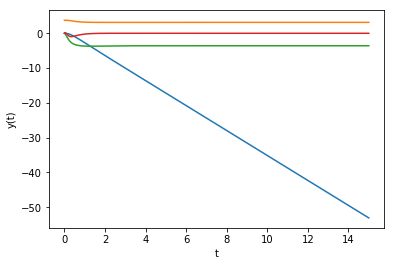

In [57]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(logger_pendulum_state.sample_times(), logger_pendulum_state.data().transpose())
plt.xlabel('t')
plt.ylabel('y(t)')

Text(0,0.5,'y(t)')

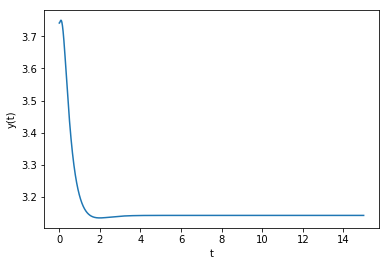

In [58]:
plt.figure()
plt.plot(logger_pendulum_state.sample_times(), logger_pendulum_state.data()[1,:].transpose())
plt.xlabel('t')
plt.ylabel('y(t)')